## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [38]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [39]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [40]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [41]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [42]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [43]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [44]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [45]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [46]:
target = 'survived'

In [47]:
vars_num = ['age', 'fare']

vars_cat = ['pclass', 'sibsp', 'parch', 'sex', 'cabin', 'embarked', 'title']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 2
Number of categorical variables: 7


### Find missing values in variables

In [48]:
# first in numerical variables
miss_no = data[vars_num].isnull().sum().sort_values(ascending=False)
miss_no


age     263
fare      1
dtype: int64

In [49]:
# now in categorical variables
miss_cat = data[vars_cat].isnull().sum().sort_values(ascending=False)
miss_cat


cabin       1014
embarked       2
pclass         0
sibsp          0
parch          0
sex            0
title          0
dtype: int64

### Determine cardinality of categorical variables

In [50]:
#number of distinct elements
for var in vars_cat:
    print(var, ' contains ', len(data[var].unique()), ' labels')

pclass  contains  3  labels
sibsp  contains  7  labels
parch  contains  8  labels
sex  contains  2  labels
cabin  contains  182  labels
embarked  contains  4  labels
title  contains  5  labels


### Determine the distribution of numerical variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f411de7fa60>,
      dtype=object)

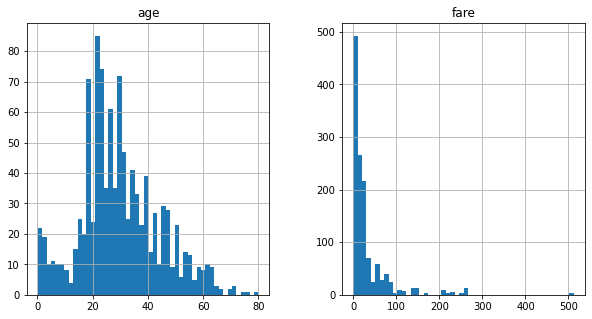

In [51]:
#knowing the spread of data
data[vars_num].hist(bins=50, figsize=(10,5))

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [53]:
X_train['cabin'] = X_train['cabin'].str[0]
X_test['cabin'] = X_test['cabin'].str[0]
X_train['cabin']

1118    NaN
44        E
1072    NaN
1130    NaN
574     NaN
       ... 
763     NaN
835     NaN
1216    NaN
559     NaN
684     NaN
Name: cabin, Length: 1047, dtype: object

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [54]:
for var in vars_num:
    # train
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
    # test
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)


In [55]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,male,25.0,0,0,7.9250,NaN,S,Mr,0,0
44,1,female,41.0,0,0,134.5000,E,C,Miss,0,0
1072,3,male,NaN,0,0,7.7333,NaN,Q,Mr,1,0
1130,3,female,18.0,0,0,7.7750,NaN,S,Miss,0,0
574,2,male,29.0,1,0,21.0000,NaN,S,Mr,0,0


### Replace Missing data in categorical variables with the string **Missing**

In [56]:
for var in vars_cat:
    X_train[var].fillna('Missing', inplace=True)
    X_test[var].fillna('Missing', inplace=True)

In [70]:
X_train.isnull().sum()

age              170
fare               1
age_na             0
fare_na            0
pclass_2           0
pclass_3           0
sibsp_1            0
parch_1            0
parch_2            0
sex_male           0
cabin_C            0
cabin_Missing      0
embarked_Q         0
embarked_S         0
title_Mr           0
title_Mrs          0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [57]:
def remove_less(df, y):
    data = pd.concat([df, y], axis=1)
    for var in vars_cat:
        percent = data[var].value_counts(normalize=True).to_dict()
        rare = [k for k in percent.keys() if percent[k] < 0.05]

        for label in rare:
            data.drop(data[data[var] == label].index, inplace=True)
    return data.drop(target, axis=1), data[target]

In [58]:
X_train, y_train = remove_less(X_train, y_train)


In [59]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na
1118,3,male,25.0,0,0,7.9250,Missing,S,Mr,0,0
1072,3,male,NaN,0,0,7.7333,Missing,Q,Mr,1,0
1130,3,female,18.0,0,0,7.7750,Missing,S,Miss,0,0
574,2,male,29.0,1,0,21.0000,Missing,S,Mr,0,0
500,2,male,46.0,0,0,26.0000,Missing,S,Mr,0,0


### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [60]:
X_train = pd.get_dummies(X_train, columns=vars_cat, drop_first=True)
X_test = pd.get_dummies(X_test, columns=vars_cat, drop_first=True)

In [61]:
X_train.columns

Index(['age', 'fare', 'age_na', 'fare_na', 'pclass_2', 'pclass_3', 'sibsp_1',
       'parch_1', 'parch_2', 'sex_male', 'cabin_C', 'cabin_Missing',
       'embarked_Q', 'embarked_S', 'title_Mr', 'title_Mrs'],
      dtype='object')

In [62]:
X_test.columns

Index(['age', 'fare', 'age_na', 'fare_na', 'pclass_2', 'pclass_3', 'sibsp_1',
       'sibsp_2', 'sibsp_3', 'sibsp_4', 'parch_1', 'parch_2', 'parch_3',
       'parch_4', 'parch_5', 'parch_9', 'sex_male', 'cabin_B', 'cabin_C',
       'cabin_D', 'cabin_E', 'cabin_F', 'cabin_G', 'cabin_Missing',
       'embarked_Q', 'embarked_S', 'title_Miss', 'title_Mr', 'title_Mrs',
       'title_Other'],
      dtype='object')

In [63]:
X_test=X_test[['age', 'fare', 'age_na', 'fare_na', 'pclass_2', 'pclass_3', 'sibsp_1',
       'parch_1', 'parch_2', 'sex_male', 'cabin_C', 'cabin_Missing',
       'embarked_Q', 'embarked_S', 'title_Mr', 'title_Mrs']]

In [71]:
X_train.isnull().sum()

age              170
fare               1
age_na             0
fare_na            0
pclass_2           0
pclass_3           0
sibsp_1            0
parch_1            0
parch_2            0
sex_male           0
cabin_C            0
cabin_Missing      0
embarked_Q         0
embarked_S         0
title_Mr           0
title_Mrs          0
dtype: int64

In [73]:
X_train.isnull().dropna

<bound method DataFrame.dropna of         age   fare  age_na  fare_na  pclass_2  pclass_3  sibsp_1  parch_1  \
1118  False  False   False    False     False     False    False    False   
1072   True  False   False    False     False     False    False    False   
1130  False  False   False    False     False     False    False    False   
574   False  False   False    False     False     False    False    False   
500   False  False   False    False     False     False    False    False   
...     ...    ...     ...      ...       ...       ...      ...      ...   
763   False  False   False    False     False     False    False    False   
835    True  False   False    False     False     False    False    False   
1216   True  False   False    False     False     False    False    False   
559   False  False   False    False     False     False    False    False   
684   False  False   False    False     False     False    False    False   

      parch_2  sex_male  cabin_C  cabin_M

In [81]:

X_train['age'] = X_train['age'].fillna(0)
X_train['fare'] = X_train['fare'].fillna(0)
X_train.isnull().sum()

age              0
fare             0
age_na           0
fare_na          0
pclass_2         0
pclass_3         0
sibsp_1          0
parch_1          0
parch_2          0
sex_male         0
cabin_C          0
cabin_Missing    0
embarked_Q       0
embarked_S       0
title_Mr         0
title_Mrs        0
dtype: int64

### Scale the variables

- Use the standard scaler from Scikit-learn

In [85]:

X_test.isnull().sum()

age              57
fare              0
age_na            0
fare_na           0
pclass_2          0
pclass_3          0
sibsp_1           0
parch_1           0
parch_2           0
sex_male          0
cabin_C           0
cabin_Missing     0
embarked_Q        0
embarked_S        0
title_Mr          0
title_Mrs         0
dtype: int64

In [87]:
X_test['age'] = X_test['age'].fillna(0)
X_test.isnull().sum()

age              0
fare             0
age_na           0
fare_na          0
pclass_2         0
pclass_3         0
sibsp_1          0
parch_1          0
parch_2          0
sex_male         0
cabin_C          0
cabin_Missing    0
embarked_Q       0
embarked_S       0
title_Mr         0
title_Mrs        0
dtype: int64

In [88]:
scale = StandardScaler() 
X_train[vars_num] = scale.fit_transform(X_train[vars_num])
X_test[vars_num] = scale.fit_transform(X_test[vars_num])

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [89]:
lr_model = LogisticRegression(C=0.0005, random_state=0)

lr_model.fit(X_train, y_train)


LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [90]:
y_pred = lr_model.predict(X_test)
y_pred_prob = lr_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_prob)
acc_score = accuracy_score(y_test, y_pred)

print(f"ROC-AUC Score : {roc_auc}")
print(f"Accuracy Score : {acc_score}")

ROC-AUC Score : 0.8253086419753086
Accuracy Score : 0.6183206106870229


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**